In [31]:
!pip install pandas matplotlib scikit-learn

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
data_path = "./data/simulated_dataset/all_data.csv"

In [34]:
df = pd.read_csv(data_path)

In [35]:
sensor_labels = df["sensor_id"].unique()

In [36]:
id1_sensor = df[df["sensor_id"] == sensor_labels[0]]

In [37]:
id1_sensor["timestamp"] = sorted(pd.to_datetime(id1_sensor["timestamp"]))
subset = id1_sensor[:20000]

/tmp/ipykernel_24115/3123496768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id1_sensor["timestamp"] = sorted(pd.to_datetime(id1_sensor["timestamp"]))


In [38]:
id1_sensor[id1_sensor["label"] == 2].count()

timestamp      0
sensor_id      0
temperature    0
label          0
dtype: int64

<Axes: title={'center': 'Temperature over Time'}, xlabel='timestamp'>

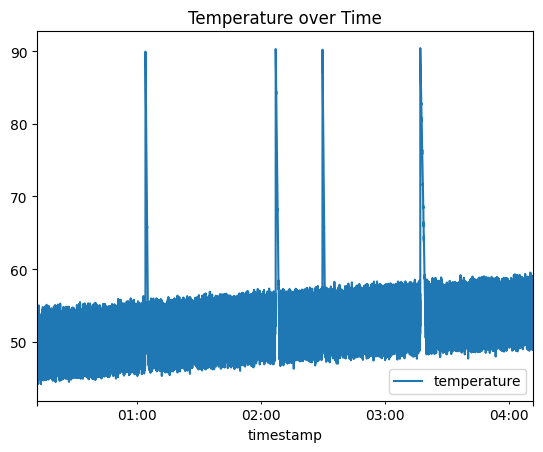

In [39]:
subset.plot.line(x="timestamp", y="temperature", title="Temperature over Time")

# Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['unix_timestamp'] = df['timestamp'].apply(lambda x: x.timestamp())

In [42]:
sensor_id = 1
sensor_df = df[df['sensor_id'] == sensor_id].reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
sensor_df['temperature'] = scalar.fit_transform(sensor_df[['temperature']])

In [44]:
n = len(sensor_df)
offset = int(np.floor(n * 0.8))
X_train, y_train = sensor_df['unix_timestamp'][:offset], sensor_df['temperature'][:offset]
X_test, y_test = sensor_df['unix_timestamp'][offset:], sensor_df['temperature'][offset:]

In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11520,) (11520,)
(2881,) (2881,)


# Understanding Prediction Horizon

The prediction horizon (how far ahead we can predict) depends on two factors:
1. How we structure our sequences
2. Whether we use single-step or multi-step prediction

Currently, your model is structured for single-step prediction, meaning it predicts one time step ahead. Let's modify it to show both single-step and multi-step predictions.

In [46]:
# Create sequences for time series prediction
def create_sequences(data, seq_length, forecast_horizon):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length:i + seq_length + forecast_horizon])
    return np.array(sequences), np.array(targets)

# Parameters
seq_length = 10  # Look at past 50 time steps
future_steps = 1  # Predict 10 steps ahead

# Prepare sequences
X_train_seq, y_train_seq = create_sequences(y_train.values, seq_length, future_steps)
X_test_seq, y_test_seq = create_sequences(y_test.values, seq_length, future_steps)

In [47]:
X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((11510, 10), (11510, 1), (2871, 10), (2871, 1))

In [48]:
# (batch_size/num_samples, seq_length, features)
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[1], 1)

In [49]:
X_train_seq.shape, X_test_seq.shape

((11510, 10, 1), (2871, 10, 1))

In [50]:
validation_split = int(np.floor(len(X_train_seq) * 0.8))
X_val_seq = X_train_seq[validation_split:]
y_val_seq = y_train_seq[validation_split:]

X_train_seq = X_train_seq[:validation_split]
y_train_seq = y_train_seq[:validation_split]

In [51]:
X_train_seq.shape, X_val_seq.shape

((9208, 10, 1), (2302, 10, 1))

In [52]:
# Create a CNN model for multi-step prediction
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(future_steps))

/home/redninjale/AFTAC-DL/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-21 12:40:18.959745: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,057 (101.79 KB)

 Trainable params: 26,057 (101.79 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Compile the model
# Mean Squared Error for regression
model.compile(optimizer='adam', loss='mse')  

# Train the model
model.fit(X_train_seq, y_train_seq, epochs=40, batch_size=32, validation_data=(X_val_seq, 
y_val_seq), verbose=2)

# Make predictions
y_pred = model.predict(X_test_seq)

Epoch 1/40
288/288 - 1s - 4ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 2/40
288/288 - 1s - 2ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 3/40
288/288 - 1s - 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 4/40
288/288 - 1s - 2ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 5/40
288/288 - 1s - 2ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 6/40
288/288 - 1s - 2ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 7/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 8/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 9/40
288/288 - 1s - 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 10/40
288/288 - 1s - 2ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 11/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 12/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 13/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 14/40
288/288 - 1s - 2ms/step - loss: 0.0042 - val_loss: 0.0046
Epoch 15/40
288/288 - 1s - 2m

In [55]:
temp_x = np.linspace(0, seq_length, seq_length)
temp_y = np.linspace(seq_length + 1, seq_length + future_steps, future_steps)

In [56]:
y_pred[3]

array([0.18364164], dtype=float32)

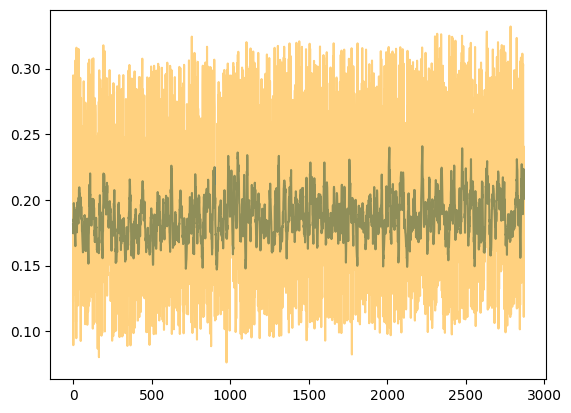

In [57]:
y_pred_flattened = y_pred.flatten()

plt.plot(range(0, len(y_pred_flattened)), y_pred_flattened)
plt.plot(range(0, len(y_pred_flattened)), y_test_seq, c='orange', alpha=0.5)

In [58]:
def calculate_msre(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse)

In [59]:
calculate_msre(y_pred_flattened, y_test_seq)

np.float64(0.06808661418979561)

# Optimizers